content 디렉토리가 구글 클라우드의 리눅스의 개인 계정을 위한 home 디렉토리라고 생각하면 됨


<div><div class="highlight-default notranslate"><div class="highlight"><pre><span></span>content/
├─ scripts/ (Google Drive Mount)
│  └─ preprocessing/
├─ models/
│  ├─ community/
│  ├─ official/
│  ├─ orbit/
│  ├─ research/
│  └─ ...
└─ workspace/ (Google Drive Mount)
    └─ training_demo/
</pre></div>


<div><div class="highlight-default notranslate"><div class="highlight"><pre><span></span>training_demo/
├─ annotations/
├─ exported-models/
├─ images/
│  ├─ test/
│  └─ train/
├─ models/
├─ pre-trained-models/
└─ README.md
</pre></div>

* annotations: This folder will be used to store all *.csv files and the respective TensorFlow *.record files, which contain the list of annotations for our dataset images.

* exported-models: This folder will be used to store exported versions of our trained model(s).

* images: This folder contains a copy of all the images in our dataset, as well as the respective *.xml files produced for each one, once labelImg is used to annotate objects.

   * images/train: This folder contains a copy of all images, and the respective *.xml files, which will be used to train our model.

   * images/test: This folder contains a copy of all images, and the respective *.xml files, which will be used to test our model.

* models: This folder will contain a sub-folder for each of training job. Each subfolder will contain the training pipeline configuration file *.config, as well as all files generated during the training and evaluation of our model.

* pre-trained-models: This folder will contain the downloaded pre-trained models, which shall be used as a starting checkpoint for our training jobs.

In [1]:
from google.colab import drive
drive.mount('/content/google_drive')

Mounted at /content/google_drive


In [2]:
import os
import pathlib
import time

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
# import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [3]:
import re
from shutil import copyfile
import argparse
import math
import random

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

In [ ]:
%%bash
mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace"
mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/scripts"
mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/scripts/preprocessing"
mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo"
mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/exported-models"
mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images"
mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/annotations"
mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images/test"
mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images/train"
mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models"
mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/pre-trained-models"


구글드라이브에 workspace를 구성하기 위해 단 한번만 아래의 압축파일 복사와 압축 해제 명령어를 수행한다.

In [ ]:
!pwd

/content


In [ ]:
!cp "/content/google_drive/MyDrive/datasets/VOCtrainval_11-May-2012.tar" ./

In [ ]:
# !tar -xvf /content/VOCtrainval_11-May-2012.tar 

In [ ]:
!tar -xvf ./VOCtrainval_11-May-2012.tar 

In [ ]:
!ls -al

total 1952804
drwxr-xr-x 1 root root       4096 Nov 16 00:13 .
drwxr-xr-x 1 root root       4096 Nov 16 00:02 ..
drwxr-xr-x 4 root root       4096 Nov 14 14:31 .config
drwx------ 5 root root       4096 Nov 16 00:09 google_drive
drwxr-xr-x 1 root root       4096 Nov 14 14:32 sample_data
drwxrwxrwx 3 root root       4096 May 11  2012 VOCdevkit
-rw------- 1 root root 1999639040 Nov 16 00:13 VOCtrainval_11-May-2012.tar


In [ ]:
%cd ./VOCdevkit/VOC2012/JPEGImages/

/content/VOCdevkit/VOC2012/JPEGImages


JPEGImage 디렉토리안에 17,125개의 파일이 존재하면 정상적인 압축해제가 수행됨

In [ ]:
!ls -l | grep ^- | wc -l

17125


In [ ]:
%cd /content

/content


In [ ]:
imageDir = "/content/VOCdevkit/VOC2012/JPEGImages"

In [ ]:
images = [f for f in os.listdir(imageDir)
              if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(?i)(.jpg|.jpeg|.png)$', f)]        # 리눅스 정규식 표현 : 파일에 a-z,A-Z,0-9라 적혀있는 파일이면 모두 가져온다.

In [ ]:
ratio=0.1

In [ ]:
num_images = len(images)
num_test_images = math.ceil(ratio*num_images)
num_train_images = num_images - num_test_images

print("num_images=", num_images)
print("num_test_images=", num_test_images)
print("num_train_images=", num_train_images)

num_images= 17125
num_test_images= 1713
num_train_images= 15412


In [ ]:
train_dir = "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images/train"
test_dir = "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images/test"

In [ ]:
source = imageDir

In [ ]:
copy_xml=True

In [ ]:
sourceXML="/content/VOCdevkit/VOC2012/Annotations"

In [ ]:
filename = images[0]
print(filename)


2012_000625.jpg


In [ ]:
type(filename)

str

In [ ]:
len(filename)

15

In [ ]:
splistring = os.path.splitext(filename)
print(type(splistring))
print(splistring)

<class 'tuple'>
('2012_000625', '.jpg')


In [ ]:
os.path.splitext(filename)[0]

'2012_000625'

In [ ]:
xmls_filename = os.path.splitext(filename)[0]+'.xml'
print(xmls_filename)

2012_000625.xml


In [ ]:
len(images)

17125

In [ ]:
print("source=", source)
print("xmls_filename=", xmls_filename)
print(os.path.join(source, xmls_filename))  # source와 xmls_filename 사이에 '/'를 삽입

source= /content/VOCdevkit/VOC2012/JPEGImages
xmls_filename= 2012_000625.xml
/content/VOCdevkit/VOC2012/JPEGImages/2012_000625.xml


In [ ]:
for i in range(num_test_images):
  idx = random.randint(0, len(images)-1)
  filename = images[idx]
  copyfile(os.path.join(source, filename), os.path.join(test_dir, filename))
  if copy_xml:
    xml_filename = os.path.splitext(filename)[0]+'.xml'
    copyfile(os.path.join(sourceXML, xml_filename), os.path.join(test_dir,xml_filename))

  images.remove(images[idx])

# for filename in images:
#   copyfile(os.path.join(source, filename), os.path.join(train_dir, filename))
#   if copy_xml:
#     xml_filename = os.path.splitext(filename)[0]+'.xml'
#     print(copyfile(os.path.join(sourceXML, xml_filename), os.path.join(train_dir, xml_filename)))

In [ ]:
%%bash
cd "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images/test"
ls -l | grep ^- | wc -l

3426


In [ ]:
%pwd

'/content/VOCdevkit/VOC2012/JPEGImages'

In [ ]:
for filename in images:
  copyfile(os.path.join(source, filename), os.path.join(train_dir, filename))
  if copy_xml:
    xml_filename = os.path.splitext(filename)[0]+'.xml'
    print(copyfile(os.path.join(sourceXML, xml_filename), os.path.join(train_dir, xml_filename)))

In [ ]:
%%bash
cd "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images/train"
ls -l | grep ^- | wc -l

30824


15,412 * 2 = 30,824

In [ ]:
!pwd

/content


In [ ]:
!nvidia-smi

Wed Nov 16 00:34:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# This Colab requires TF 2.5.
!pip install -U "tensorflow>=2.5"

In [ ]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pwd

/content


In [ ]:
%cd /content/

/content


In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3533, done.
remote: Counting objects: 100% (3533/3533), done.
remote: Compressing objects: 100% (2941/2941), done.
remote: Total 3533 (delta 930), reused 1472 (delta 538), pack-reused 0
Receiving objects: 100% (3533/3533), 47.01 MiB | 15.27 MiB/s, done.
Resolving deltas: 100% (930/930), done.


리눅스 계열
* 데이반 : 소프트웨어 설치 방식 : apt[S/W 설치 프로그램]

* 레드햇 : 소프트웨어 설치 방식 : yum[S/W 설치 프로그램]

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd /content/models/research/
protoc object_detection/protos/*.proto --python_out=.
cd /content
git clone https://github.com/cocodataset/cocoapi.git
cd /content/cocoapi/PythonAPI
make
cp -r pycocotools /content/models/research/
cd /content/models/research/
cp object_detection/packages/tf2/setup.py .
python -m pip install .
cd /content

In [ ]:
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

In [ ]:
!cp "/content/models/research/object_detection/data/pascal_label_map.pbtxt" \
"/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/annotations"

In [ ]:
!mv "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/annotations/pascal_label_map.pbtxt" \
"/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/annotations/label_map.pbtxt"

In [ ]:
!pwd

/content


In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

In [ ]:
from collections import namedtuple
import xml.etree.ElementTree as ET

In [ ]:
def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.

    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)
        for member in root.findall('object'):
            bndbox = member.find('bndbox')
            xminf = float(bndbox.find('xmin').text)
            yminf = float(bndbox.find('ymin').text)
            xmaxf = float(bndbox.find('xmax').text)
            ymaxf = float(bndbox.find('ymax').text)
            value = (filename,
                     width,
                     height,
                     member.find('name').text,
                     int(xminf),
                     int(yminf),
                     int(xmaxf),
                     int(ymaxf),
                    #  int(bndbox.find('xmin').text),
                    #  int(bndbox.find('ymin').text),
                    #  int(bndbox.find('xmax').text),
                    #  int(bndbox.find('ymax').text),
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
output_path = "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/annotations/traintest.record"
image_dir = "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images/train"
xml_dir = "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images/train"

In [ ]:

import glob
import pandas as pd
import tensorflow.compat.v1 as tf

In [ ]:
writer = tf.python_io.TFRecordWriter(output_path)
path = os.path.join(image_dir)
examples = xml_to_csv(xml_dir)
print(examples)

              filename  width  height   class  xmin  ymin  xmax  ymax
0      2012_000625.jpg    500     333  person    17   178   114   333
1      2012_000625.jpg    500     333  person   291   202   368   333
2      2012_000625.jpg    500     333  person   433   245   500   312
3      2012_000625.jpg    500     333  person   189   241   225   306
4      2012_001452.jpg    367     500  person    80    33   362   500
...                ...    ...     ...     ...   ...   ...   ...   ...
36031  2011_004117.jpg    500     333  person    52   135   139   311
36032  2011_004117.jpg    500     333  person   182   111   265   275
36033  2011_004117.jpg    500     333  person   306    92   375   246
36034  2011_004117.jpg    500     333  person   416    71   486   222
36035  2008_004740.jpg    323     500  person     8     1   323   500

[36036 rows x 8 columns]


In [ ]:
type(examples)

pandas.core.frame.DataFrame

In [ ]:
len(examples)

36036

In [ ]:
Point = namedtuple('Point', ['x', 'y'])
Point.__doc__                   # docstring for the new class

'Point(x, y)'

In [ ]:
p = Point(11, y=22)             # instantiate with positional args or keywords
p[0] + p[1]                     # indexable like a plain tuple

33

In [ ]:
x, y = p                        # unpack like a regular tuple
x, y

(11, 22)

In [ ]:
p.x + p.y                       # fields also accessible by name

33

In [ ]:
d = p._asdict()                 # convert to a dictionary
d['x']

11

In [ ]:
Point(**d)                      # convert from a dictionary
# Point(x=11, y=22)

Point(x=11, y=22)

In [ ]:
p._replace(x=100)               # _replace() is like str.replace() but targets named fields


Point(x=100, y=22)

In [ ]:
def splitX(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [ ]:
# data = namedtuple('data', ['filename', 'object'])
gb = examples.groupby('filename')
print(gb)


In [ ]:
print(gb.groups.keys())

dict_keys(['2007_000027.jpg', '2007_000032.jpg', '2007_000033.jpg', '2007_000039.jpg', '2007_000042.jpg', '2007_000061.jpg', '2007_000121.jpg', '2007_000123.jpg', '2007_000129.jpg', '2007_000170.jpg', '2007_000175.jpg', '2007_000187.jpg', '2007_000241.jpg', '2007_000243.jpg', '2007_000250.jpg', '2007_000256.jpg', '2007_000272.jpg', '2007_000323.jpg', '2007_000332.jpg', '2007_000333.jpg', '2007_000346.jpg', '2007_000363.jpg', '2007_000364.jpg', '2007_000392.jpg', '2007_000423.jpg', '2007_000452.jpg', '2007_000464.jpg', '2007_000480.jpg', '2007_000491.jpg', '2007_000528.jpg', '2007_000529.jpg', '2007_000549.jpg', '2007_000559.jpg', '2007_000572.jpg', '2007_000584.jpg', '2007_000629.jpg', '2007_000636.jpg', '2007_000645.jpg', '2007_000648.jpg', '2007_000661.jpg', '2007_000663.jpg', '2007_000664.jpg', '2007_000676.jpg', '2007_000713.jpg', '2007_000720.jpg', '2007_000727.jpg', '2007_000738.jpg', '2007_000762.jpg', '2007_000768.jpg', '2007_000783.jpg', '2007_000793.jpg', '2007_000799.jpg', '

In [ ]:
print(gb.groups)

{'2007_000027.jpg': [6289], '2007_000032.jpg': [10434, 10435, 10436, 10437], '2007_000033.jpg': [35579, 35580, 35581], '2007_000039.jpg': [5995], '2007_000042.jpg': [32551, 32552], '2007_000061.jpg': [13817, 13818], '2007_000121.jpg': [291, 292], '2007_000123.jpg': [18885], '2007_000129.jpg': [35365, 35366, 35367, 35368, 35369, 35370], '2007_000170.jpg': [30796, 30797, 30798, 30799, 30800, 30801], '2007_000175.jpg': [6837], '2007_000187.jpg': [4698], '2007_000241.jpg': [19733, 19734, 19735], '2007_000243.jpg': [8232], '2007_000250.jpg': [4447, 4448], '2007_000256.jpg': [29621], '2007_000272.jpg': [23984], '2007_000323.jpg': [12496, 12497], '2007_000332.jpg': [30655], '2007_000333.jpg': [25416], '2007_000346.jpg': [32870, 32871, 32872, 32873], '2007_000363.jpg': [895, 896], '2007_000364.jpg': [9746, 9747, 9748], '2007_000392.jpg': [21450, 21451], '2007_000423.jpg': [9706, 9707], '2007_000452.jpg': [14190, 14191], '2007_000464.jpg': [2226, 2227], '2007_000480.jpg': [8345, 8346, 8347, 834

In [ ]:
stopiter = 0
for filename, x in zip(gb.groups.keys(), gb.groups):
  print(filename)  
  print(gb.get_group(x))
  stopiter += 1
  print("**")
  if (stopiter > 5):
    break

2007_000027.jpg
             filename  width  height   class  xmin  ymin  xmax  ymax
6289  2007_000027.jpg    486     500  person   174   101   349   351
**
2007_000032.jpg
              filename  width  height      class  xmin  ymin  xmax  ymax
10434  2007_000032.jpg    500     281  aeroplane   104    78   375   183
10435  2007_000032.jpg    500     281  aeroplane   133    88   197   123
10436  2007_000032.jpg    500     281     person   195   180   213   229
10437  2007_000032.jpg    500     281     person    26   189    44   238
**
2007_000033.jpg
              filename  width  height      class  xmin  ymin  xmax  ymax
35579  2007_000033.jpg    500     366  aeroplane     9   107   499   263
35580  2007_000033.jpg    500     366  aeroplane   421   200   482   226
35581  2007_000033.jpg    500     366  aeroplane   325   188   411   223
**
2007_000039.jpg
             filename  width  height      class  xmin  ymin  xmax  ymax
5995  2007_000039.jpg    500     375  tvmonitor   156    89 

In [ ]:
showimage_path = "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images/train/2007_000032.jpg"

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [ ]:
image_np = load_image_into_numpy_array(showimage_path)

In [ ]:
%matplotlib inline

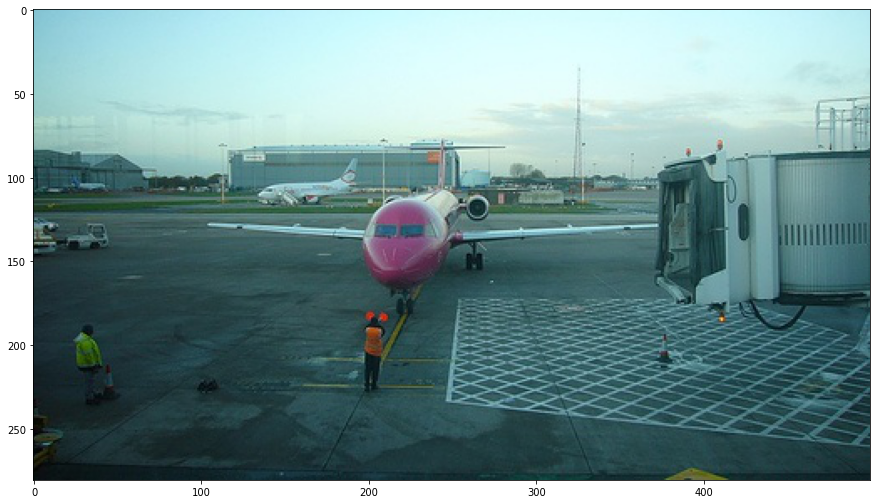

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(image_np)
plt.show()

In [ ]:
grouped = splitX(examples, 'filename')
# for group in grouped:
#   # tf_example = create_tf_example(group, path)
#   # writer.write(tf_example.SerializeToString())
# writer.close()

In [ ]:
print(grouped)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
!python /content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/scripts/preprocessing/generate_tfrecord.py \
-x "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images/train" \
-l "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/annotations/label_map.pbtxt" \
-o "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/annotations/train.record"

['2022-11-14 05:22:10.486484: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered',
 'Successfully created the TFRecord file: /content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/annotations/train.record']

In [ ]:
!python generate_tfrecord.py \
-x "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/images/test" \
-l "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/annotations/label_map.pbtxt" \
-o "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/annotations/test.record"

['2022-11-14 05:23:55.310605: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered',
 'Successfully created the TFRecord file: /content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/annotations/test.record']

In [ ]:
!pwd

/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/scripts/preprocessing


In [ ]:
%cd /content

/content


In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz

--2022-11-14 05:27:09--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.12.128, 2404:6800:4003:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.12.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211996178 (202M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_resnet5 100%[===================>] 202.17M  54.6MB/s    in 3.7s    

2022-11-14 05:27:13 (54.6 MB/s) - ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’ saved [211996178/211996178]



In [ ]:
!tar xvfzp "/content/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz" \
-C "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/pre-trained-models"

faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/checkpoint
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/pipeline.config
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/saved_model.pb
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/variables/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/variables/variables.index


In [ ]:
!mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models/myft_faster_rcnn_resnet50_v1"

In [ ]:
!cp "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/pipeline.config" \
"/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models/myft_faster_rcnn_resnet50_v1"

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir="/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models/myft_faster_rcnn_resnet50_v1"

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
--model_dir="/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models/myft_faster_rcnn_resnet50_v1" \
--pipeline_config_path="/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models/myft_faster_rcnn_resnet50_v1/pipeline.config"

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
--model_dir="/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models/myft_faster_rcnn_resnet50_v1" \
--pipeline_config_path="/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models/myft_faster_rcnn_resnet50_v1/pipeline.config" \
--checkpoint_dir="/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models/myft_faster_rcnn_resnet50_v1"

In [ ]:
!ps 

In [ ]:
!kill 

In [ ]:
%tensorboard --logdir="/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models/myft_faster_rcnn_resnet50_v1"

In [ ]:
!mkdir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/exported-models/saved_faster_rcnn_resnet50_v1"

In [ ]:
!python /content/models/research/object_detection/exporter_main_v2.py \
--input_type image_tensor \
--pipeline_config_path "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models/myft_faster_rcnn_resnet50_v1/pipeline.config" \
--trained_checkpoint_dir "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/models/myft_faster_rcnn_resnet50_v1" \
--output_directory "/content/google_drive/MyDrive/Tensorflow_OD_API/faster_rcnn_resnet50_v1/workspace/training_demo/exported-models/saved_faster_rcnn_resnet50_v1"